In [1]:
%matplotlib inline
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)


# Bayesian Hypothesis Testing for comparing two groups

Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``

# Reference for Bayesian t-test


> Kruschke J, **Doing Bayesian Data Analysis**, Ch. 12

# Drug trial evaluation

* We  want to  evaluate  of a drug that is supposed to increase intelligence.

* We have IQ measures  of:
    * 47 individuals receiving the drug  (treatment group)
    * 42 individuals  receiving the placebo (control group). 
    
* Some observations are however far from the mean.

In [2]:
iq_drug = np.array ([101,100,102,104,105,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,104,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,103,103,100,101,103,104,100,101])
iq_placebo = np.array ([ 99,101,100,101,99,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,98,99])



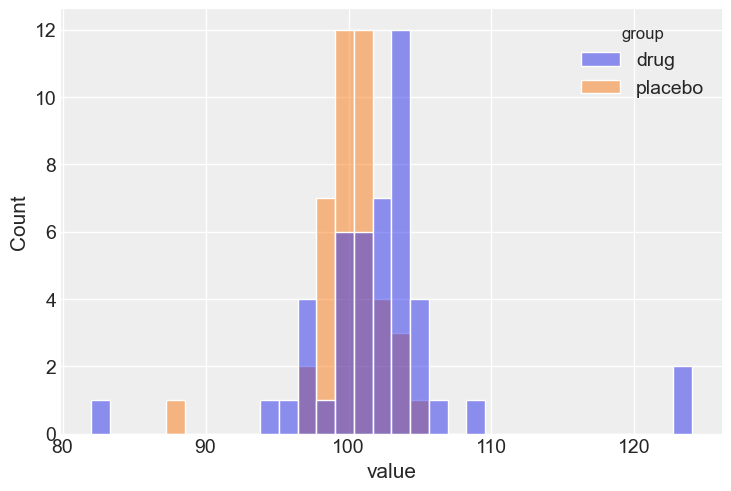

In [3]:
y  = pd.DataFrame(dict(value=np.r_[iq_drug, iq_placebo], group=np.r_[['drug']*len(iq_drug), ['placebo']*len(iq_placebo)]))
sns.histplot(data=y, x="value", hue="group");

# Research question

* The sample mean of the drug group  is superior, but:

    * there is a lot of variability within groups
    * there are some outliers.



* Is the drug credibly associated to a higher  IQ? 

# Setup

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{y}_1$, $\bar{y}_2$) 

    * sample standard deviations ($s_1, s_2$) 

    * numerosity ($n_1, n_2$)


* The sample are drawn from two populations with unknown parameters $\mu_1, \mu_2, \sigma_1, \sigma_2$.

# Different research questions

* We will make inference (compute the posterior density of) about the difference between the mean of the two populations, $\mu_1 - \mu_2$


* Based on the posterior density, we can answer different questions.


* In this example, we will answer all these questions. In general, one defines only a single question, even though by looking at them all provides richer information. 

# Different research questions

 * Is it credible that two groups have equal means? Answer: check whether the HDI of $\mu_1 - \mu_2$ includes  0.
     
     
 * Which is the probability of the drug having a positive effect? Answer:  posterior probability $P(\mu_1 - \mu_2 >0)$ 


* Which is the probability of drug having a slight / medium / strong effect? Answer:  posterior probability of $\mu_1 - \mu_2$ falling into certain intervals.

# Main idea

* We will fit a normal-normal model on each group.


* Then we will study the posterior distribution of the difference ($\mu_1 - \mu_2$)


* Recall the normal-normal model:
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}


# Background information to set the prior

* The IQ can be interpreted according to the <a href="https://www.123test.com/interpretation-of-an-iq-score/"> IQ scale meaning </a>.

    * its  mean in the population is  about 100
    * the IQ is assumed  to be normally distributed; its mean  can be assumed to be in (80, 120). 
    * extreme values of IQ  are 60 ( cognitively impaired) and 140 (gifted). A plausible value of standard deviation in the population is thus   (100 - 60)/2 = 20.



# Prior for $\mu_{\text{drug}}$ and $\mu_{\text{placebo}}$

* The  mean IQ of the population  lies in (80, 120);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{drug}}   \sim  N (100, 10 )
$$
$$
\mu_{\text{placebo}}   \sim  N (100, 10 )
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.



In [4]:
#Here we tune the half-normal prior for sigma, adjusting the scale to have the median close to 20.
from scipy.stats import halfnorm
# this yields a  diffuse prior, but still defined over plausible range. 
pd.DataFrame(halfnorm.rvs(scale=30, size=10000)).describe()

,0
count,10000.000000
mean,24.089939
std,18.145484
min,0.004981
25%,9.808766
50%,20.401381
75%,34.519428
max,114.781916


## Likelihood


* Assuming a Gaussian distribution of the observations,  we have:

$$\vec{y}_{drug} \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}})$$

$$\vec{y}_{placebo} \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})$$

where we use the vector notation to make it clear that these are array of measures.



#  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).

\begin{align*}
\mu_{\text{drug}} & \sim N(100,10) \\
\sigma_{\text{drug}} & \sim \text{half-normal} (30) \\
\vec{y}_{\text{drug}}  & \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}}) \\
\\
\mu_{\text{placebo}} & \sim N(100,10) \\
\sigma_{\text{placebo}} & \sim \text{half-normal} (30) \\
\vec{y}_{\text{placebo}}  & \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})\\
\end{align*}


# Comparing two means $\mu_1$ and $\mu_2$

We consider  the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

* We  can define it   as a *deterministic* variables in PyMC3, as it is a deterministic function of two parameters.


* We will have the posterior samples of ($\mu_1 - \mu_2$) in the trace.

In [5]:

with pm.Model() as  normal_model:
    #prior
    mu_drug         = pm.Normal     ('mu_drug',  mu = 100,  sigma = 10)
    mu_placebo      = pm.Normal     ('mu_placebo', mu = 100,  sigma = 10)
    sigma_drug      = pm.HalfNormal ('sigma_drug',  sigma=30)
    sigma_placebo   = pm.HalfNormal ('sigma_placebo', sigma=30)

    
    #likelihood of group 1
    y_drug         = pm.Normal  ('y_1',  mu=mu_drug,      sigma=sigma_drug,       observed= iq_drug)
    
    #likelihood of group 2
    y_placebo   = pm.Normal  ('y_2',  mu=mu_placebo, sigma=sigma_placebo, observed= iq_placebo)
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_drug - mu_placebo)


In [6]:
with normal_model:
    normal_trace    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_drug, mu_placebo, sigma_drug, sigma_placebo]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


# Checking convergence

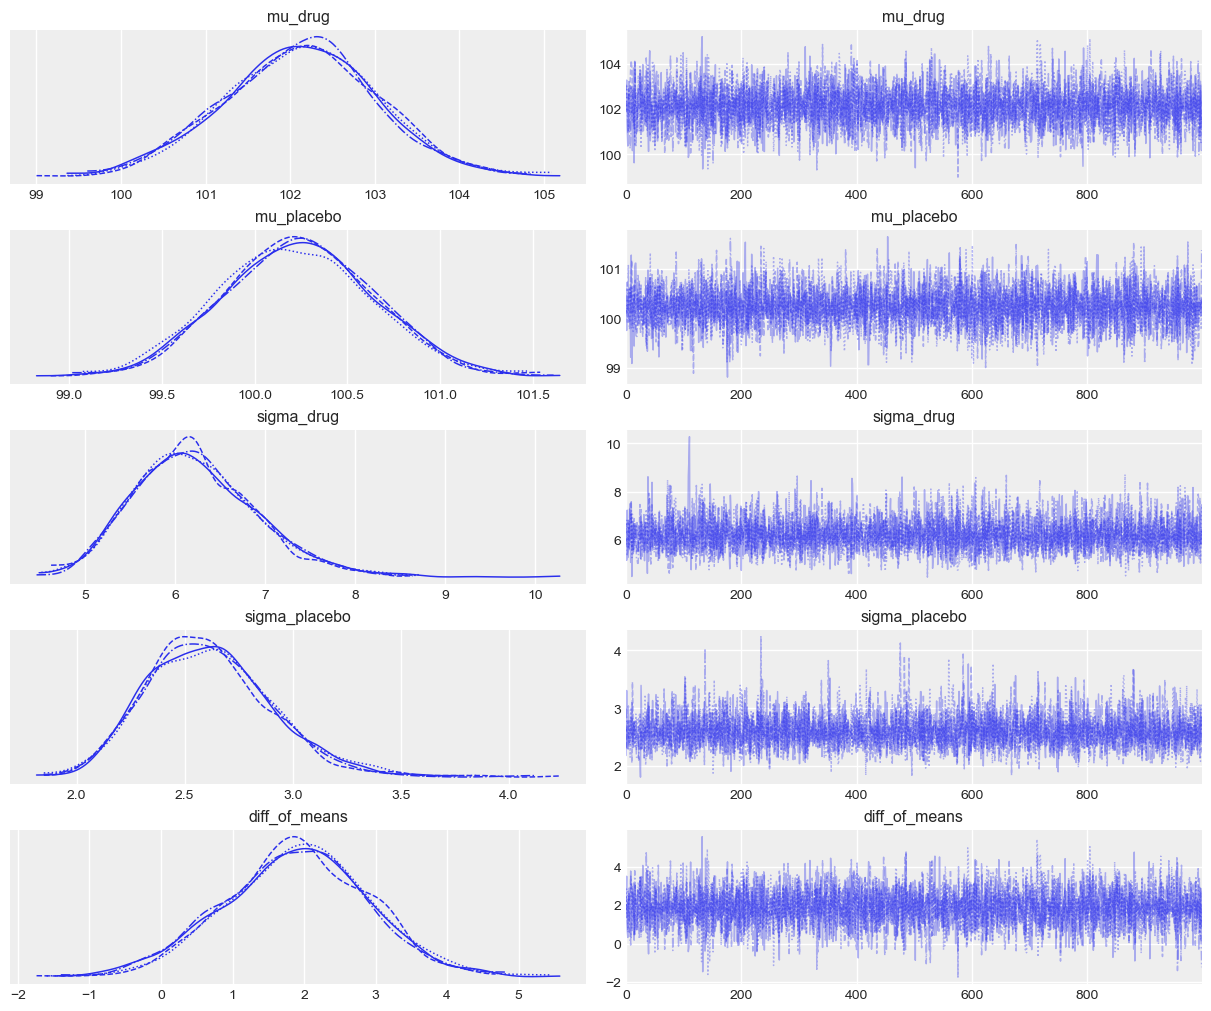

In [7]:
#sampling was good. The posterior of sigma is very similar for both groups, while there are differences in  the posterior mean of the two groups.
az.plot_trace(normal_trace);

In [8]:
# The posterior distribution can be checked in different ways, depending on the question we want to answer.

#Possible question 1: is the hypothesis of equal means of the two populations plausible?
#In traditional hypothesis testing, this corresponds to test the  hypothesis diff mu = 0.
#Formally the 0 is a plausible value (although at the very limit of the 95% HDI) 
az.summary(normal_trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug,102.127,0.905,100.285,103.837,0.012,0.008,5860.0,3245.0,1.0
mu_placebo,100.235,0.407,99.429,100.985,0.005,0.004,6247.0,3206.0,1.0
sigma_drug,6.221,0.681,4.952,7.577,0.009,0.006,6361.0,2823.0,1.0
sigma_placebo,2.616,0.292,2.059,3.164,0.004,0.003,5602.0,3183.0,1.0
diff_of_means,1.892,0.999,-0.132,3.785,0.012,0.010,6554.0,3432.0,1.0


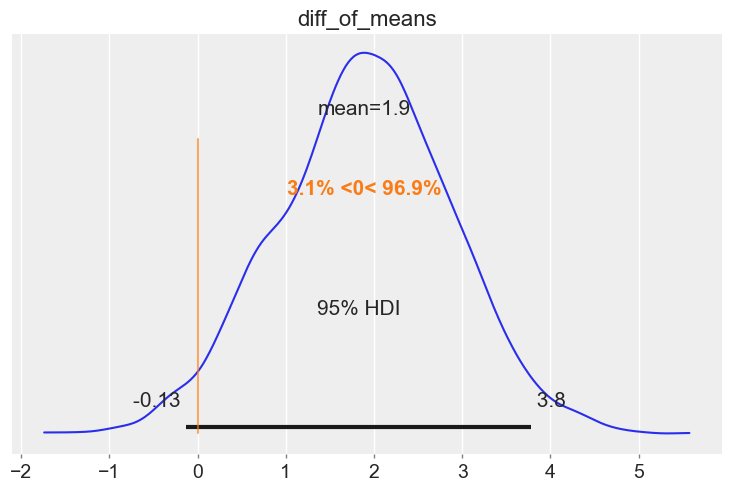

In [9]:
# Possible question 2: which is the posterior probability of a  positive effect?
#There is a  probability >95% of the effect being positive; thus we accept the hypothesis of a positive effect.
az.plot_posterior(normal_trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

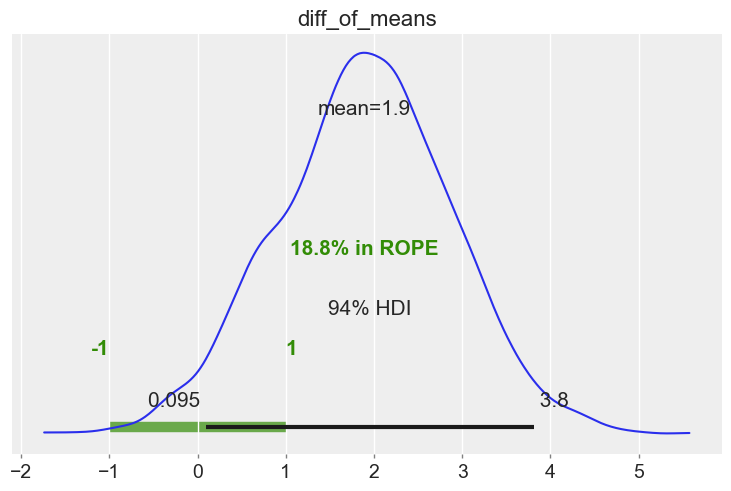

In [10]:
#Possible question #3
# Assuming the differences of +-1 are practically negligible, we define the rope as [-1, +1].
# Which is the probability of the effect being practically negligible or practically significant?
# The probability of rope is shown in figure, 
#we compute in the next slide  the probability of the positive effect being significant by working on the samples of the trace 
az.plot_posterior(normal_trace,  var_names="diff_of_means", rope=[-1,1]);

In [11]:
#Computing the probability of the positive effect being practically positive, practically negative or practically equivalent by working with the trace.
# This is a more detailed answer compared to the previous ones.
samples                  = az.extract(normal_trace)
diff_samples             = samples.diff_of_means.values
p_significant_positive   =  ( (diff_samples > 1).sum() ) / len(diff_samples)
p_significant_negative   = ( (diff_samples < -1).sum()) / len(diff_samples)
p_practically_eq         = 1-  p_significant_negative  -  p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.810
p_practically_eq:  0.188
p_significant_negative:  0.002


# Posterior predictive checks

Sampling: [y_1, y_2]


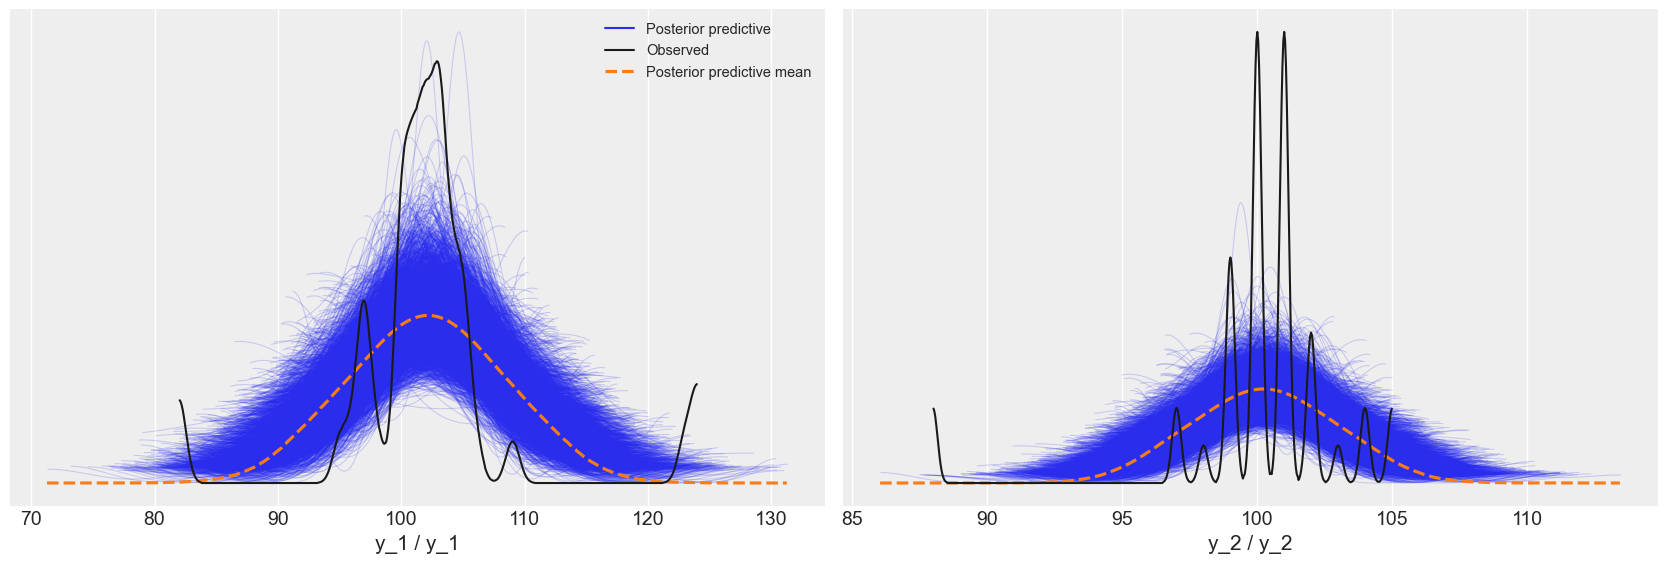

In [13]:
# Quiz yourself: write a pseudo code explaining what the code below does.
with normal_model:
     ppc = pm.sample_posterior_predictive(normal_trace)
    
# The density is too low in the bulk of the distribution, for both groups. 
az.plot_ppc(ppc);

## Robust likelihood

* The density is too low in the center of the distribution.


* We now adopt   as likelihood function a Student-t distribution with 4 degrees of freedom:


$$y_{\text{drug},i} \sim StudentT(\mu_{\text{drug}}, \sigma_{\text{drug}}, \nu=4)$$

$$y_{\text{placebo},i} \sim StudentT(\mu_{\text{placebo}}, \sigma_{\text{placebo}},  \nu=4)$$


In [14]:
with pm.Model() as student_model:
    #prior are  unchanged.
    mu_drug_t         = pm.Normal    ('mu_drug_t',     mu = 100,  sigma = 5)
    mu_placebo_t      = pm.Normal    ('mu_placebo_t',   mu = 100,  sigma = 5)
    sigma_drug_t      = pm.HalfNormal ('sigma_drug_t',  sigma=25)
    sigma_placebo_t   = pm.HalfNormal ('sigma_placebo_t', sigma=25)

    #But now we adopt a robust likelihood. 
    #For simplicity we use a Student T with nu=4.  A more sophisticated approach would be to put a prior also on nu, but
    #that makes the model much more sensitive on the prior choice. 
    y_drug = pm.StudentT ('y_drug',       nu=4, mu=mu_drug_t, sigma=sigma_drug_t,       observed= iq_drug)
    y_placebo = pm.StudentT ('y_placebo', nu=4, mu=mu_placebo_t, sigma=sigma_placebo_t, observed= iq_placebo)
    
    #Derived quantities:
    diff_of_means_t = pm.Deterministic('diff_of_means', mu_drug_t - mu_placebo_t)
    student_trace    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_drug_t, mu_placebo_t, sigma_drug_t, sigma_placebo_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [ ]:
#the fit is better compare to the normal model, though not yet perfect for the placebo group.
with student_model:
    ppc_t = pm.sample_posterior_predictive(student_trace)
    az.plot_ppc(ppc_t);

In [16]:
# the sigma decreases by almost a half compared to the Gaussian model, as the student distribution filters outliers.
# as a results, the hdi become shorter, and the amount of difference between the two groups becomes clearer.
pd.concat( [az.summary(student_trace,  hdi_prob=0.95), az.summary(normal_trace, hdi_prob=0.95) ])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug_t,101.793,0.500,100.764,102.727,0.007,0.005,5508.0,3258.0,1.0
mu_placebo_t,100.431,0.253,99.970,100.974,0.003,0.002,6517.0,3196.0,1.0
sigma_drug_t,2.991,0.461,2.165,3.946,0.007,0.005,5133.0,3307.0,1.0
sigma_placebo_t,1.409,0.216,1.030,1.847,0.003,0.002,5338.0,2668.0,1.0
diff_of_means,1.362,0.563,0.226,2.433,0.008,0.005,5620.0,3309.0,1.0
mu_drug,102.127,0.905,100.285,103.837,0.012,0.008,5860.0,3245.0,1.0
mu_placebo,100.235,0.407,99.429,100.985,0.005,0.004,6247.0,3206.0,1.0
sigma_drug,6.221,0.681,4.952,7.577,0.009,0.006,6361.0,2823.0,1.0
sigma_placebo,2.616,0.292,2.059,3.164,0.004,0.003,5602.0,3183.0,1.0
diff_of_means,1.892,0.999,-0.132,3.785,0.012,0.010,6554.0,3432.0,1.0


# Re-answering questions with the robust model

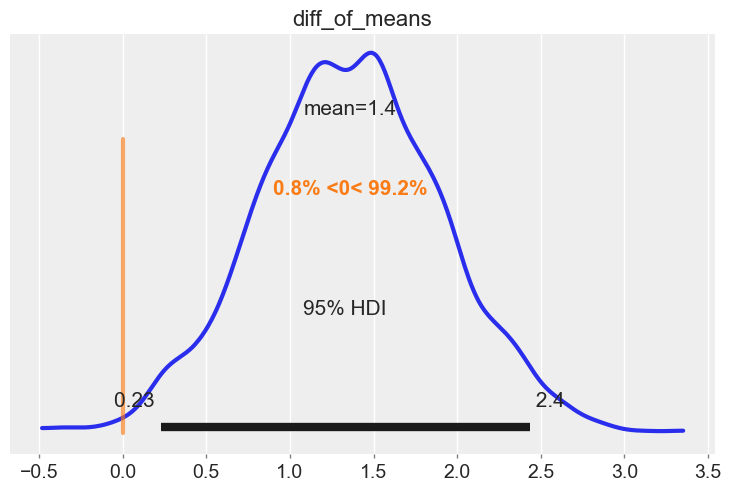

In [17]:
# with the robust likelihood, the 0 is no longer within the HDI; it is no longer a plausible value.
# This model rejects the hypothesis of the two populations having the same mean.

az.plot_posterior(student_trace, var_names=['diff_of_means'],  ref_val=0, linewidth=3, hdi_prob=0.95);

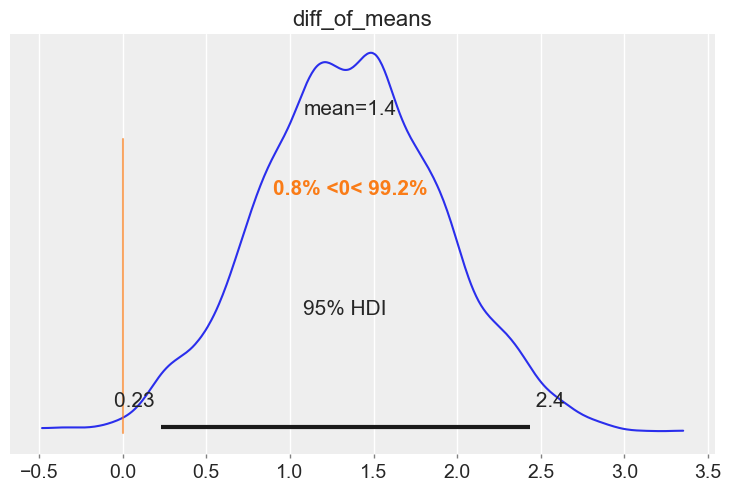

In [18]:
# Posterior probability of a  positive effect according to the robust model (increases wrt the Gaussian model).
az.plot_posterior(student_trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

In [20]:
#Posterior probability of the positive effect being practically positive, practically negative or practically equivalent, 
#according to the robust model.

student_samples             = az.extract(student_trace)
diff_samples                = student_samples.diff_of_means.values
p_significant_positive      =  ( (diff_samples > 1).sum() ) / len(diff_samples)
p_significant_negative      = ( (diff_samples < -1).sum()) / len(diff_samples)
p_practically_eq            = 1-  p_significant_negative  -  p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.742
p_practically_eq:  0.258
p_significant_negative:  0.000


# Discussion

* The  analysis of the posterior density of $\mu_1 - \mu_2$ allows making decision about the drug.


* In this case the Student likelihood was a better option than the normal one, but it is not always the case.  How to decide between models which have different likelihoods? Wait some lectures for the WAIC, a criterion for model selection.

# Your turn (1): effect size

A further indicator used to  compare the means of the two populations is *effect size* (Cohen's $d$):

$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sigma_P}$$ 

where  $\sigma_P$ is the pooled standard deviation,  $\sigma_P = \sqrt{ \frac{\sigma_2^2 + \sigma_1^2}{2} }$

* Effect size is  the amount of change induced by the treatment relative to the standard deviation. It is often used in medical studies.

# Effect size

* Compute the posterior probability of the effect size being:

    * negative ($d < 0$)

    * positive small ($0 \leq d \leq 0.3$)

    * positive, medium strenght  ($0.3 \leq d \leq 0.8$)

    * positive, large ($d >  0.8$)



* Hints:

    * define `effect_size` as a deterministic variable of the model.

    * use `extract_dataset` to access the samples of the trace.

# Your turn (2): analyze a case study

* An experiment was performed to estimate the effect of beta-blockers on mortality of cardiac patients, which in general is comprised between 1% and 10%.


* Out of 674 patients of  the control group 39 died;  out of 680 receiving the treatment, 22 died. 


* Assume that the outcomes are independent and binomially distributed, with  probabilities of death   $\theta_{\text{control}}$ and $\theta_{\text{treatment}}$. 


* Analyze the posterior distribution of the difference between the probability of death in the two groups. 

# Hints


* To visually tune the Beta prior, you can use https://keisan.casio.com/exec/system/1180573226


* The syntax for the binomial likelihood in pymc is `pm.Binomial('variable_name', n=number of trials, p = theta, observed= number of successes)`

# Solutions

In [26]:
#computing the effect size as a deterministic variable within the student model.

with pm.Model() as student_model_effect:
    #prior are  unchanged.
    mu_drug_t           = pm.Normal     ('mu_drug_t',       mu = 100,  sigma = 5)
    mu_placebo_t        = pm.Normal     ('mu_placebo_t',    mu = 100,  sigma = 5)
    sigma_drug_t        = pm.HalfNormal ('sigma_drug_t',    sigma=25)
    sigma_placebo_t     = pm.HalfNormal ('sigma_placebo_t', sigma=25)

    y_drug = pm.StudentT ('y_drug',       nu=4, mu=mu_drug_t,  sigma=sigma_drug_t,       observed= iq_drug)
    y_placebo = pm.StudentT ('y_placebo', nu=4, mu=mu_placebo_t, sigma=sigma_placebo_t, observed= iq_placebo)
    
    #Effect size as a deterministic variable.
    effect_size         = pm.Deterministic('effect_size', (mu_drug_t - mu_placebo_t) / (  (sigma_drug_t**2 + sigma_placebo_t**2) /2 )**(1/2))
    student_trace_effect    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_drug_t, mu_placebo_t, sigma_drug_t, sigma_placebo_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [27]:
#Posterior probability of the effect size being negative, or positive  (disaggregated as small, medium and large).
samples                  = az.extract_dataset(student_trace_effect)
effect_samples      = samples.effect_size.values

# count the samples in which the effect size negative
p_negative             = ( ( (effect_samples<0).sum() ) /  len (effect_samples) )

#a slightly more complex syntax is necessary to count the sample within a given range
p_small                   =  np.logical_and(effect_samples > 0,  effect_samples < 0.3)
p_small                   =  p_small.sum() / len (effect_samples) 

p_medium             =  np.logical_and(effect_samples > 0.3,  effect_samples < 0.8)
p_medium             =  p_medium.sum() / len (effect_samples) 

p_large                   = ( ( (effect_samples>0.8).sum() ) /  len (effect_samples) )

print("p_negative: ", "%.3f" % p_negative)
print("p_small: ", "%.3f" % p_small)
print("p_medium: ", "%.3f" % p_medium)
print("p_large: ", "%.3f" % p_large)

#check the computed probs sum up to 1
print ("sum: ", p_large + p_medium + p_small + p_negative)

p_negative:  0.009
p_small:  0.116
p_medium:  0.665
p_large:  0.210
sum:  1.0


/var/folders/2k/rgs_y6s556x557660m9wmrfc0000gp/T/ipykernel_87763/3030277268.py:2: FutureWarning: extract_dataset has been deprecated, please use extract
  samples                  = az.extract_dataset(student_trace_effect)


In [28]:
# Analysis of the mortality using the beta-binomial model
# A Beta(5,100) has expected value 0.05, and most of its mass below 0.1. This represents  appropriately our prior information.

with pm.Model() as binomial_diff:
    theta_treatment = pm.Beta('theta_treatment', alpha=5, beta=100)
    theta_control   =  pm.Beta('theta_control', alpha=5, beta=100)
    
    #we need to write the model using the binomial likelihood
    dead_treatment = pm.Binomial ('dead_treatment ',  p=theta_treatment, observed=22, n=680)
    dead_control   = pm.Binomial ('dead_control ',       p=theta_control, observed=39, n=674)
    
    #Difference between the two mortality rates is a deterministic variable.
    diff_theta      = pm.Deterministic('diff_theta', theta_treatment - theta_control)
    binomial_trace  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_treatment, theta_control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [24]:
#The posterrio mean for the death rates are 0.034 for the control group and 0.056 for the treatment group. 
az.summary(binomial_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_treatment,0.034,0.006,0.022,0.046,0.0,0.0,3806.0,2669.0,1.0
theta_control,0.056,0.008,0.042,0.072,0.0,0.0,3993.0,2987.0,1.0
diff_theta,-0.022,0.010,-0.041,-0.002,0.0,0.0,3800.0,3084.0,1.0


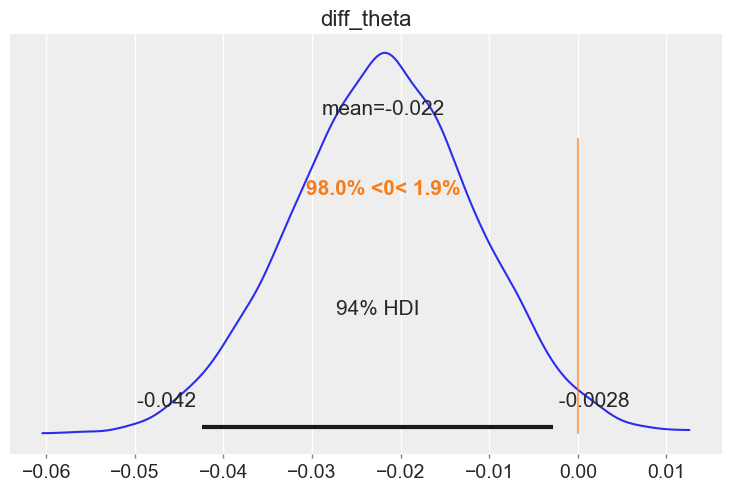

In [29]:
# The HDI does not contain the 0; it rejects the hypothesis of the two groups having the same probability of death.

# We also accept the hypothesis of the treatment reducing the mortality rate, as there is probability > 95%
# of the  treatment reducing the mortality rate.
# A more detailed analysis could consider different intervals, and report the posterior probability of the treament being slightly / medium/ very effective. 
az.plot_posterior(binomial_trace, var_names='diff_theta', ref_val=0);
